In [192]:
import json
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [254]:
# Importing the dataset.
# The LIDAR server produces samples at 30Hz with object positions normalized in their
# space, i.e. x and y values are in the 0-1 range.
datadir = Path("../testdata")
names = [
    "dump-1731964073793.jsonl",
    "dump-1731965089198.jsonl",
    "dump-1731966752296.jsonl",
    "dump-1732220377000.jsonl",
    "dump-1732378712139.jsonl"
]

data = []
for name in names:
    path = datadir.joinpath(datadir, name)
    f = open(path, 'r')
    last_is_zero = False
    points = []
    for line in f.readlines():
        d = json.loads(line)
        if d['type'] != 'object':
            continue
        payload = d['payload']
        # At the beginning and end of the session there is nobody on stage and
        # there are many 0,0 points.
        is_zero = payload['x'] == 0 and payload['y'] == 0
        if is_zero:
            continue
            
        points.append({
            'x': payload['x'],
            'y': payload['y'],
        })
    data.append(points)

In [255]:
class SequenceToSequenceDataset(Dataset):
    # Instead of predicting the next point, we make the network predict
    # the next trajectory. This way, it will be forced to imitate the
    # behaviour of the training setup.
    def __init__(self, data, sequence_length=90):
        self.sequence_length = sequence_length

        for points in data:     
            # Convert data to numpy array
            xy_points = np.array([[d['x'], d['y']] for d in points])
        
            # Create sequences
            self.sequences = []
            self.targets = []
        
            for i in range(len(xy_points) - (sequence_length * 2)):
                start = i
                mid = i + sequence_length
                end = mid + sequence_length
            
                self.sequences.append(xy_points[start:mid])
                self.targets.append(xy_points[mid:end])
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.as_tensor([self.sequences[idx], self.targets[idx]], dtype=torch.float32)

In [256]:
# Checking that the dataset works.
dataset = SequenceToSequenceDataset(data)
next(iter(dataset)).shape

torch.Size([2, 90, 2])

In [257]:
class TrajectoryPredictor(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128, lstm_layers=3, dense_layers=[64, 32, 16], output_dim=2):
        super(TrajectoryPredictor, self).__init__()
        
        # LSTM layers for temporal processing
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            batch_first=True
        )
        
        # Fully connected layers for further feature processing
        dense_layers_list = []
        input_size = hidden_dim
        for layer_size in dense_layers:
            dense_layers_list.append(nn.Linear(input_size, layer_size))
            dense_layers_list.append(nn.ReLU())
            input_size = layer_size
        self.fc = nn.Sequential(*dense_layers_list)
        
        # Output layer with Sigmoid activation
        self.output_layer = nn.Linear(input_size, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x: (batch_size, input_sequence_length, input_dim)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, input_sequence_length, hidden_dim)
        dense_out = self.fc(lstm_out)  # Pass each timestep's hidden state through dense layers
        output = self.sigmoid(self.output_layer(dense_out))  # Output: (batch_size, input_sequence_length, output_dim)
        return output

In [252]:
# Checking that the model works
model = TrajectoryPredictor()
with torch.no_grad():
    dummy_input = torch.rand(1, 5, 2)
    # Forward pass
    output = model(dummy_input)
    print(output) 

tensor([[[0.5558, 0.5719],
         [0.5559, 0.5719],
         [0.5560, 0.5719],
         [0.5560, 0.5719],
         [0.5561, 0.5719]]])


In [286]:
# Training
from accelerate import Accelerator
import torch
import shutil
import os
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import wandb



# Initialize Accelerator
accelerator = Accelerator()

current_date = datetime.now().strftime("%Y-%m-%d")
num_epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float("inf")
epochs_without_improvement = 0
best_path = ""

# Hyperparams
lr = 1e-3
sequence_length=90
hidden_dim=128
lstm_layers=2
dense_layers=[128, 64, 32, 16]
batch_size = 32

# Initialize the dataset
dataset = SequenceToSequenceDataset(data, sequence_length=sequence_length)

# Define split ratios
train_ratio = 0.8
val_ratio = 0.2

# Compute split sizes
dataset_size = len(dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Split dataset
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Define model, optimizer, and loss function
model = TrajectoryPredictor(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dense_layers=dense_layers)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()  # Mean Squared Error for position regression

# Prepare everything with Accelerate
model, optimizer, train_loader, val_loader = accelerator.prepare(
    model, optimizer, train_loader, val_loader
)

run = wandb.init(
    # set the wandb project where this run will be logged
    project="afterlife",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "LSTM",
    "dataset": "MAX",
    "epochs": num_epochs,
    "sequence_length":sequence_length,
    "hidden_dim": hidden_dim,
    "lstm_layers": lstm_layers,
    "dense_layers": dense_layers,
    "batch_size": batch_size
    }
)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training"):
        inputs, targets = batch[:, 0], batch[:, 1]

        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, targets)  # Compute loss
        accelerator.backward(loss)  # Backpropagation using Accelerate
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            inputs, targets = batch[:, 0], batch[:, 1]
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    # Log results
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    wandb.log({"train_loss": train_loss, "val_loss": val_loss})

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        path = f"../snapshots/snapshot-{current_date}_best_model_epoch_{epoch + 1}"
        accelerator.save_state(path)
        best_path = f"{path}/model.safetensors"
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered!")
            break

# Final cleanup
output_path = f"../models/{run.name}.safetensors"
os.rename(best_path, output_path)
shutil.rmtree("../snapshots")

print(f"Training complete. Model is stored at {output_path}. Best Validation Loss: {best_val_loss}")
wandb.finish()

Validating: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 147.71it/s]


Epoch 1/1 - Train Loss: 0.0487, Val Loss: 0.0438
Training complete. Model is stored at ../models/royal-flower-6.safetensors. Best Validation Loss: 0.043828637637900854


train_loss,▁
val_loss,▁
train_loss,0.04874
val_loss,0.04383


In [270]:
import torch
from safetensors.torch import load_file

trained_model = TrajectoryPredictor(hidden_dim=hidden_dim, lstm_layers=lstm_layers, dense_layers=dense_layers)

# Load the parameters from the safetensors file
path = best_path
state_dict = load_file(path)

# Load the state_dict into your model
trained_model.load_state_dict(state_dict)

# Move model to the appropriate device (e.g., CPU or GPU)
device = torch.device("mps")
trained_model.to(device)

TrajectoryPredictor(
  (lstm): LSTM(2, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=16, out_features=2, bias=True)
  (sigmoid): Sigmoid()
)

In [271]:
eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
item = next(iter(eval_loader)).squeeze(0)[0]
item.shape

torch.Size([90, 2])

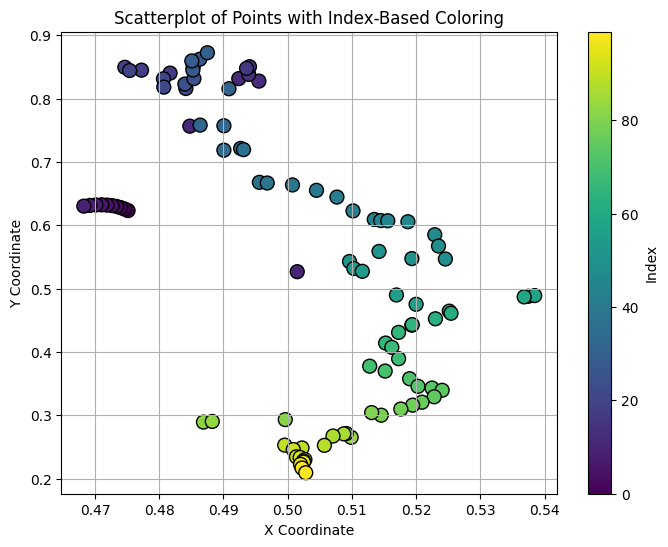

In [285]:
import matplotlib.pyplot as plt
import numpy as np

item = next(iter(eval_loader)).squeeze(0)[0]
item.shape

with torch.no_grad():
    predicted = trained_model(item.to(device))
    
predicted = predicted.squeeze(0).detach().cpu()
plot_data = torch.cat((have, predicted), dim=0)

# Extract x, y coordinates
x, y = plot_data[:, 0], plot_data[:, 1]

# Generate colors based on indices
colors = np.arange(len(plot_data))

# Create scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=colors, cmap='viridis', s=100, edgecolor='k')

# Add colorbar
plt.colorbar(scatter, label="Index")

# Add labels and grid
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Scatterplot of Points with Index-Based Coloring")
plt.grid(True)
plt.show()